## Unraveling the Linguistic Evolution in the Makeup Community (NLP)

Business Goal: 

Language serves as more than a mere means of communication in the ever-evolving realm of beauty and cosmetics; it also serves as an indicator of consumer preferences, cultural changes, and emerging trends. The aim of this study is to analyze the linguistic terrain of the "MakeupAddiction" subreddit, tracing the development of colloquialisms and terminology utilized in the cosmetics community between 2021 and 2023. By looking at the rise, fall, and possible demise of certain words, we hope to create a linguistic mirror that shows how the cosmetics industry has changed in a broader sense. These observations can assist brands, influencers, and enthusiasts in comprehending the changing preferences of the community and remaining informed about the most recent terminology.


Technical Proposal: 

Preserve and cleanse all pertinent textual information contained in the "MakeupAddiction" subreddit remarks and posts within the allotted time period. Incorporate NLP methodologies, such as tokenization and lemmatization, to facilitate text normalization. Use TF-IDF to do an industry-specific diachronic linguistic analysis to find and connect important changes in terminology that have happened over time. Deliver conclusions using dynamic visual representations and produce a report that interprets linguistic shifts in order to provide industry stakeholders with strategic insights. Develop, if desired, a predictive model for predicting forthcoming trends in language pertaining to cosmetics.


### Step 1: Set Up PySpark Session and Read Data from S3

In [4]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
# install Python Reddit API Wrapper for getting external data Karma
%pip install pyspark==3.2.0
%pip install praw

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.7.22          |  py310h06a4308_0         153 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, ArrayType, IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
import pyspark.sql.functions as F

# Building Spark Session
spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider")
    .getOrCreate()
)

# Read data from S3
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_submissions = "project/submissions/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_submissions}"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")
sampled_submissions = submissions.sample(withReplacement=False, fraction=0.1, seed=123)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-820c7030-767d-46b4-b18f-3b2287756969;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 298ms :: artifacts dl 19ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://sagemaker-us-east-1-729491017256/project/submissions/yyyy=*


23/11/19 21:04:13 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
23/11/19 21:04:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


shape of the submissions dataframe is 95,932x68


### Step 2: Data Preprocessing

In [3]:
from pyspark.sql.functions import lower, col, regexp_replace, udf, explode, desc, length, StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, explode

def clean_text(text):
    import re  
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove short words (less than 3 characters)
    text = ' '.join([word for word in text.split() if len(word) > 2])
    return text

clean_text_udf = udf(clean_text, StringType())

# Apply the cleaning function to the submissions dataset
sampled_submissions = sampled_submissions.withColumn('clean_text', clean_text_udf(col('selftext')))

# Drop NA values and rows with empty 'clean_text'
sampled_submissions = sampled_submissions.na.drop(subset=["clean_text"])
sampled_submissions = sampled_submissions.filter(length(col('clean_text')) > 0)

# Tokenize the cleaned text
tokenizer = Tokenizer(inputCol='clean_text', outputCol='words')
tokenized_submission = tokenizer.transform(sampled_submissions)

# Remove stop words
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words')
clean_submission = remover.transform(tokenized_submission)

### Step 3: Calculate TF-IDF

In [4]:
from pyspark.ml.feature import HashingTF, IDF

# Hashing TF
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures")
featurized_data = hashingTF.transform(clean_submission)

# IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
tfidf_data = idf_model.transform(featurized_data)


In [5]:
from pyspark.ml.feature import CountVectorizer

# Assuming 'filtered_words' is the output column from StopWordsRemover
cv = CountVectorizer(inputCol="filtered_words", outputCol="cv_features")
cv_model = cv.fit(clean_submission)  # clean_submission from your previous step

# Extract vocabulary
vocabulary = cv_model.vocabulary


In [8]:
# Extract Top Terms from TF-IDF Vectors

import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

broadcast_vocabulary = spark.sparkContext.broadcast(vocabulary)

def extract_top_terms(vector, num_terms=10):
    indices = np.argsort(vector.toArray())[-num_terms:][::-1]
    return [broadcast_vocabulary.value[i] for i in indices if i < len(broadcast_vocabulary.value)]


extract_top_terms_udf = udf(extract_top_terms, ArrayType(StringType()))

tfidf_data = tfidf_data.withColumn("top_terms", extract_top_terms_udf(col("features")))




In [9]:
from pyspark.sql.functions import year, month

# Convert 'created_utc' to timestamp if it's not already
# tfidf_data = tfidf_data.withColumn('created_utc', to_timestamp('created_utc'))

# Extract year and month
tfidf_data = tfidf_data.withColumn('year', year('created_utc'))
tfidf_data = tfidf_data.withColumn('month', month('created_utc'))



In [18]:
# Assuming the UDF 'extract_top_terms_udf' is already defined and applied
exploded_terms = tfidf_data.select('year', 'month', explode('top_terms').alias('term'))

term_trends = exploded_terms.groupBy('year', 'month', 'term').count().orderBy('year', 'month', 'count', ascending=False)
term_trends.show()


23/11/19 05:28:15 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+----+-----+----------------+-----+
|year|month|            term|count|
+----+-----+----------------+-----+
|2023|    3|       tattmatte|   48|
|2023|    3|           alike|   31|
|2023|    3|      straighten|   30|
|2023|    3|         directs|   13|
|2023|    3|         kaleido|   12|
|2023|    3|         cruical|   12|
|2023|    3|      repackages|   10|
|2023|    3|      temptation|   10|
|2023|    3|       runaround|   10|
|2023|    3|       lookbooks|    9|
|2023|    3|            jogs|    9|
|2023|    3|           robot|    9|
|2023|    3|layeringbuilding|    9|
|2023|    3|         shivers|    9|
|2023|    3|       responder|    9|
|2023|    3|        skintine|    8|
|2023|    3|          jamata|    8|
|2023|    3| differencewhich|    8|
|2023|    3|          smears|    8|
|2023|    3|           human|    7|
+----+-----+----------------+-----+
only showing top 20 rows



23/11/19 05:40:19 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


### Visualization (Using Python and Plotly):

In [19]:
# Convert to Pandas DataFrame for visualization
pdf_top_terms_monthly = term_trends.toPandas()

23/11/19 05:40:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/19 05:52:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/19 05:52:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/19 05:52:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


In [26]:
output_filepath = '../../data/csv/popular_words.csv'  # Specify your desired output path
pdf_top_terms_monthly.to_csv(output_filepath, index=False)


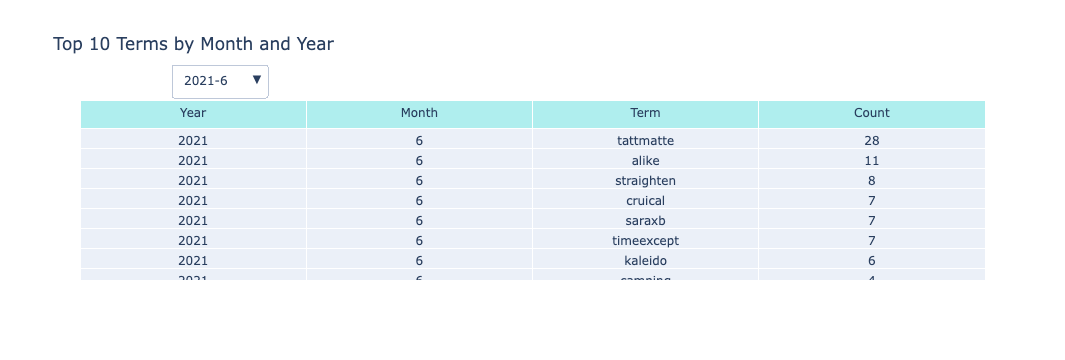

In [32]:
import pandas as pd
import plotly.graph_objects as go
# Sort DataFrame by year, month, and count for visualization and filter for top 10 terms each month
pdf_top_terms_monthly_sorted = pdf_top_terms_monthly.sort_values(by=['year', 'month', 'count'], ascending=[True, True, False])
pdf_top_terms_monthly_top10 = pdf_top_terms_monthly_sorted.groupby(['year', 'month']).head(10)
pdf_top_terms_monthly_top10.to_csv('../../data/csv/top10_popular_words.csv', index=False)

# Initialize the figure
fig = go.Figure()

# Add the table to the figure with the sorted data
fig.add_trace(go.Table(
    header=dict(values=['Year', 'Month', 'Term', 'Count'], fill_color='paleturquoise'),
    cells=dict(values=[pdf_top_terms_monthly_top10.year, 
                       pdf_top_terms_monthly_top10.month, 
                       pdf_top_terms_monthly_top10.term, 
                       pdf_top_terms_monthly_top10['count']], fill_color='lavender')
))

# Function to create a filter button
def create_filter_button(year, month):
    # Filter data based on year and month
    filtered_data = pdf_top_terms_monthly_top10[
        (pdf_top_terms_monthly_top10['year'] == year) & 
        (pdf_top_terms_monthly_top10['month'] == month)
    ]
    
    # Create a button for the filter
    return dict(
        label=f"{year}-{month}",
        method="update",
        args=[{"cells": {"values": [filtered_data.year, 
                                    filtered_data.month, 
                                    filtered_data.term, 
                                    filtered_data['count']]}}],
    )

# Add a button for selecting all data
def create_select_all_button():
    return dict(
        label="Select All",
        method="update",
        args=[{"cells": {"values": [pdf_top_terms_monthly_top10.year, 
                                    pdf_top_terms_monthly_top10.month, 
                                    pdf_top_terms_monthly_top10.term, 
                                    pdf_top_terms_monthly_top10['count']]}}],
    )

# Create filter buttons for each year and month combination, plus the 'Select All' option
buttons = [create_select_all_button()] + [
    create_filter_button(year, month)
    for year in sorted(pdf_top_terms_monthly_top10['year'].unique())
    for month in sorted(pdf_top_terms_monthly_top10['month'].unique())
]

# Add dropdown menu with buttons
fig.update_layout(
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "x": 0.1,
        "xanchor": "left",
        "y": 1.2,
        "yanchor": "top"
    }],
    title="Top 10 Terms by Month and Year"
)

# Show the figure
fig.show()

# Save the Plotly figure to an HTML file
html_file_path = '../../data/plots/nlp_yyl/top_terms_monthly_figure.html'  # Adjust the path as needed
fig.write_html(html_file_path)



"Tattmatte": This term consistently appears across multiple months and years. It could refer to a specific product, brand, or makeup technique that has sustained popularity in the community. Investigating the context in which "Tattmatte" is mentioned could provide insights into why it's so prevalent.

Seasonal Trends: Terms like "kaleido" and "straighten" appear regularly, hinting at ongoing trends or interests. "Kaleido" might refer to a color palette or style that is seasonally relevant, while "straighten" could relate to a makeup technique or tool.

Emerging Trends: The appearance of terms like "temptation," "lookbooks," and "repackages" in later years (2023) suggests new topics or products gaining traction. These could be related to new product launches or emerging makeup styles.

Yearly Comparisons: Terms such as "alike" and "cruical" show significant counts across years, indicating long-term interests or ongoing discussions in the community. Understanding the context of these terms could reveal whether they relate to product types, makeup techniques, or community-specific topics.

Specific Interests: Unique terms that appear in certain months but not others could signify time-bound events or discussions. For instance, "runaround" and "jogs" might be related to seasonal activities influencing makeup choices or could be names of specific products that were popular during those times.

User Engagement: The frequency of term mentions can be a measure of engagement or interest levels in specific topics. Higher counts indicate more active discussions or questions about those terms.

Contextual Analysis: To fully understand why certain terms are popular, it's essential to read the posts and threads where these terms appear. This will provide context – whether they're discussing new products, sharing makeup techniques, or focusing on brand reviews.

Impact of External Factors: Some terms may gain popularity due to external influences like viral social media content, celebrity endorsements, or shifts in the beauty industry.

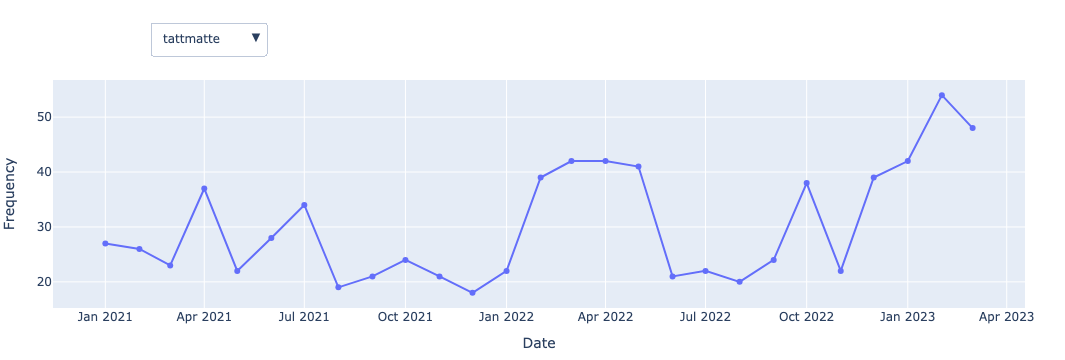

In [37]:
import plotly.graph_objects as go
import pandas as pd

# Load the DataFrame from the CSV file
pdf_top_terms_monthly = pd.read_csv('../../data/csv/top10_popular_words.csv')

# Convert 'year' and 'month' to datetime for plotting
pdf_top_terms_monthly['date'] = pd.to_datetime(pdf_top_terms_monthly[['year', 'month']].assign(DAY=1))

# Get the top 20 terms by overall frequency from the top 10 terms each month
top_terms_data = (
    pdf_top_terms_monthly.groupby('term')['count']
    .sum()
    .sort_values(ascending=False)
    .head(20)
)

# Extract the top 20 terms
top_terms = top_terms_data.index

# Initialize the figure
fig = go.Figure()

# Add line traces for each of the top 20 terms
for term in top_terms:
    # Filter the data for the current term
    term_data = pdf_top_terms_monthly[pdf_top_terms_monthly['term'] == term]
    # Add a trace for this term
    fig.add_trace(
        go.Scatter(
            x=term_data['date'],  
            y=term_data['count'],
            name=term,
            mode='lines+markers',  # Line plot with markers
            visible=True  # Set to visible as all terms are top terms now
        )
    )

# Create the buttons for the dropdown menu
dropdown_buttons = []

# Start with a button that shows all terms
dropdown_buttons.append(
    {
        'label': 'Select All',
        'method': 'update',
        'args': [{'visible': [True] * len(top_terms)}]
    }
)

# Add buttons for each term to toggle visibility independently
for i, term in enumerate(top_terms):
    # Each button has its own visibility state
    visibility_state = [False] * len(top_terms)
    visibility_state[i] = True  # Toggle i-th term

    dropdown_buttons.append(
        {
            'label': term,
            'method': 'update',
            'args': [{'visible': visibility_state}]
        }
    )

# Add dropdown menu with buttons
fig.update_layout(
    updatemenus=[
        {
            'buttons': dropdown_buttons,
            'direction': 'down',
            'pad': {"r": 10, "t": 10},
            'showactive': True,
            'x': 0.1,
            'xanchor': 'left',
            'y': 1.3,
            'yanchor': 'top'
        }
    ],
    xaxis_title='Date',
    yaxis_title='Frequency',
    legend_title='Top Terms',
    margin=dict(l=40, r=40, t=80, b=40)
)

# Show the figure
fig.show()

# Save the Plotly figure to an HTML file
html_file_path = '../../data/plots/nlp_yyl/top_20_terms.html'  # Adjust the path as needed
fig.write_html(html_file_path)


Term Analysis:

    Tattmatte (Navy Blue Line): This term shows significant variability, with the most notable peaks around October 2021 and April 2023, reaching a frequency of just over 50.
    Alike (Green Line): Exhibits moderate fluctuations, with a noticeable increase around July 2021 and a peak in early 2023.
    Straighten (Red Line): Relatively stable with minor peaks, the most notable being around April 2022.
    Kaleido (Brown Line): This line shows a gradual increase over time, with spikes that appear to be seasonal, peaking in mid-2021 and early 2023.
    Crucial (Purple Line): Shows a spike around April 2022 and maintains a low to moderate frequency at other times.
    Saraxb (Teal Line): Remains relatively low-frequency with slight peaks, the highest being around mid-2022.
    Runaround (Orange Line): This term's frequency increases in the latter half of 2022 and maintains a moderate frequency thereafter.
    Sisters (Light Blue Line): Shows occasional spikes but remains generally low in frequency.
    Lookbooks (Pink Line): After being relatively flat, it shows a peak in early 2022 and another in early 2023.
    Camping (Yellow Line): Very low frequency throughout, with no significant peaks.
    Directs (Light Green Line): Not clearly visible on the graph, indicating a very low or negligible frequency compared to the other terms.
Overall Trends:

The term "tattmatte" dominates the graph in terms of frequency, suggesting it's a highly discussed topic or term in the subreddit.
There is an observable increase in the frequency of several terms from the beginning of 2022, which might indicate an overall increase in activity or specific events that prompted discussions in the subreddit.
Seasonal or event-driven peaks suggest that some terms are associated with specific times of the year or events within the makeup community.

### Sentiment Analysis

In [2]:
%pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 9.0 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Function to get sentiment
def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

# Create UDF for sentiment analysis
sentiment_udf = udf(sentiment_analysis, FloatType())

# Assuming your DataFrame is named 'df' and the text column is 'clean_text'
df_with_sentiment = tfidf_data.withColumn("sentiment", sentiment_udf(tfidf_data['clean_text']))


In [11]:
# Convert the specific column to Pandas DataFrame for visualization
df_with_sentiment_pd = df_with_sentiment.select('sentiment').toPandas()

In [35]:
from pyspark.sql.functions import explode, col

# Explode the 'top_terms' column to individual terms
exploded_df = df_with_sentiment.withColumn("term", explode("top_terms"))

# Group by term and calculate the total count and average sentiment for the whole year
total_grouped_data = exploded_df.groupby('term').agg(
    F.count('term').alias('total_count'),
    F.mean('sentiment').alias('total_avg_sentiment')
)

# Get the top 20 terms based on total count
top_20_terms = total_grouped_data.orderBy(F.desc('total_count')).limit(20).select('term').rdd.flatMap(lambda x: x).collect()

# Filter the exploded DataFrame to only include the top 20 terms
top_terms_df = exploded_df.filter(exploded_df.term.isin(top_20_terms))

# Group by year, month, and term; then calculate average sentiment
monthly_grouped_data = top_terms_df.groupby('year', 'month', 'term').agg(
    F.mean('sentiment').alias('avg_sentiment')
)

# Convert to Pandas DataFrame for visualization
monthly_grouped_data_pd = monthly_grouped_data.toPandas()



23/11/19 21:54:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/19 21:57:55 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/19 21:57:55 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/19 22:03:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


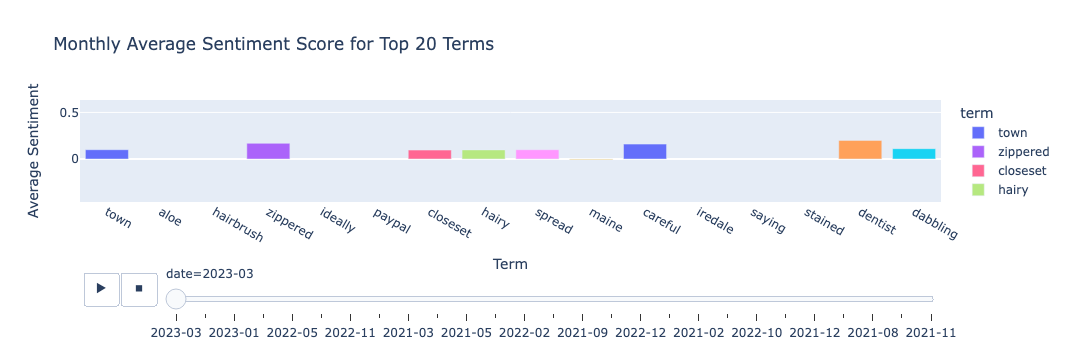

In [42]:

import pandas as pd
import plotly.express as px

# Ensure 'date' column is in a suitable string format for Plotly
monthly_grouped_data_pd['date'] = pd.to_datetime(monthly_grouped_data_pd[['year', 'month']].assign(DAY=1))
monthly_grouped_data_pd['date'] = monthly_grouped_data_pd['date'].dt.strftime('%Y-%m')

# Create a bar chart with animation
fig = px.bar(monthly_grouped_data_pd, x='term', y='avg_sentiment', color='term',
             animation_frame='date', animation_group='term',
             range_y=[monthly_grouped_data_pd.avg_sentiment.min(), monthly_grouped_data_pd.avg_sentiment.max()],
             title="Monthly Average Sentiment Score for Top 20 Terms")

fig.update_layout(showlegend=True, xaxis_title="Term", yaxis_title="Average Sentiment")
fig.show()
# Save the Plotly figure to an HTML file
html_file_path = '../../data/plots/nlp_yyl/top_20_terms_sentiment.html'  # Adjust the path as needed
fig.write_html(html_file_path)




Variability Over Time:

Stability: Some terms show relatively stable sentiment scores over time. For example, "aloe" maintains a positive sentiment throughout, suggesting consistent perception.

Fluctuation: Other terms exhibit more significant fluctuations. For instance, "zippered" and "loooove" have varied sentiment scores across different months, indicating changing perceptions or contexts in which they are discussed.
Comparative Sentiment Analysis:

Positive Terms: Terms like "aloe", "iredale", and "loooove" generally have higher sentiment scores, suggesting a positive perception.
Negative Terms: Conversely, terms like "dentist" and "hairy" occasionally dip into negative sentiment scores, indicating less favorable perceptions at times.
Contextual Trends:

Seasonal Variations: Some terms may have sentiment scores that correlate with seasons or events. For example, "hairy" and "dentist" show fluctuating sentiments possibly tied to specific events or seasons.
Consistent Terms: Terms like "spread" and "small" maintain a relatively consistent sentiment, possibly indicating a stable context or usage.
Notable Observations:

Significant Changes: Some terms show significant changes in sentiment from one year to another. For instance, "iredale" goes from negative to positive sentiment, which could be due to changing discussions or perceptions over time.
High and Low Points: The term "saying" reaches a sentiment high of 0.5 in September 2022, while "ideally" drops to -0.46 in February 2021, highlighting their most polarized sentiment moments.
Overall Sentiment Trends:

The general trend for most terms is a mix of positive and negative sentiments, indicating diverse contexts and perceptions.
Terms like "careful" and "stained" exhibit an upward trend in sentiment over time, suggesting improving perceptions or more positive contexts.



"Town":

Fluctuating Sentiment: Exhibits fluctuations from a low of -0.22 in November 2021 to a high of 0.1 in March 2023.
Notable Dip: Significant negative sentiment in November 2021, possibly due to specific events or discussions.

"Aloe":

Generally Positive: Consistently positive sentiment across months, with the highest in May 2021 (0.226) and the lowest in April 2022 (-0.102).
Stable Perception: The term seems to maintain a generally favorable perception.

"Hairbrush":

Varying Scores: Shows a wide range in sentiment from -0.125 in May 2022 to 0.25 in July 2021.
Context Sensitivity: The sentiment seems to vary possibly due to the different contexts in which it's discussed.

"Zippered":

High Positive Score: Peaks at 0.367 in February 2021.
Inconsistent Trend: Shows inconsistency in sentiment, which might suggest varied usage or context.

"Ideally":

Significant Negative in February 2021: Drops to -0.461, indicating a strongly negative perception or context.
Recovery: Shows an upward trend in sentiment in later months, reaching 0.243 in September 2021.

"PayPal":

Generally Positive: Ranges from 0.125 in February 2023 to a high of 0.376 in April 2022.
Positive Perception: Mostly positive sentiment, indicating favorable views or experiences related to PayPal.

"Hairy":

Varied Sentiment: Fluctuates from -0.102 in May 2021 to 0.18 in August 2022.
Negative Peaks: Shows negative sentiment peaks, particularly in May 2021 and September 2022.

"Spread":

Consistent Positivity: Maintains positive sentiment, peaking at 0.24 in January 2022.
Stable Positive Perception: Indicates a generally positive context or usage across different months.

"Dentist":

Mixed Sentiment: Ranges from -0.29 in March 2021 to a high of 0.4 in August 2022.
Seasonal Influence: Possible seasonal influence on sentiment, with higher positive sentiment in summer months.

"Stained":

Fluctuating Scores: Ranges from -0.016 in September 2022 to a high of 0.218 in May 2021.
Context-Dependent: The term's sentiment seems highly dependent on the context of discussion.

"Seduction":

Generally Low Scores: Maintains relatively low sentiment scores, peaking at 0.263 in August 2021.
Varied Perception: The sentiment varies, suggesting different contexts or connotations.

"Looove":

High Positive Scores: Peaks at 0.633 in May 2021, indicating a very positive context.
Negative Scores: Shows negative sentiment in 2022, indicating a shift in perception or context.

"Dabbling":

Generally Positive: Shows mostly positive sentiment, peaking at 0.148 in December 2022.
Consistent Positive Context: Suggests a generally positive or favorable context in discussions.

Conclusions:
Contextual Sensitivity: The sentiment of terms like "hairbrush", "hairy", and "zippered" is sensitive to context, showing significant fluctuations.
Stable vs. Variable Sentiments: Terms like "aloe" and "spread" maintain stable positive sentiments, while others like "dentist" and "ideally" show more variability.
Seasonal Influences: Some terms exhibit seasonal sentiment trends, as seen with "dentist" and "hairy".
Changing Perceptions: Terms like "loooove" show changing perceptions over time, evident from the shift from high positive to negative sentiments.